# Full mesh Cylinder

In [1]:
import numpy as np
import pyvista as pv
import vtk
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt

# Importing the SU2 file

In [2]:
f = open('C:\\Users\\20192167\\Documents\\Boeken\\BEP\\mesh_cylinder_lam.su2.txt', 'r')


# first get the dimensions
line = f.readline()
columns = line.split()
print(columns)

NDIME = columns[1]
print("dimensions = ",NDIME)

# then, get the nr of elements
line = f.readline()
columns = line.split()

NELEM=columns[1]
print("nr of elements=",NELEM)

# create the 2D triangle array
connectivity = np.arange(4*int(NELEM),dtype=np.int32)
connectivity = connectivity.reshape(int(NELEM),4)
                    
# now, read all the elements into a structure
for i in range(int(NELEM)):
    line=f.readline()
    columns = line.split()
    connectivity[i][:]=[int(3), int(columns[1]), int(columns[2]), int(columns[3])]
    
print("end reading elements")
# then, get the coordinates
line = f.readline()
columns = line.split()

NPOIN=columns[1]
print("nr of points=",NPOIN)

# create the 2D point array
points = np.arange(2*int(NPOIN),dtype=np.float64).reshape(int(NPOIN),2)
# now, read all the points into a structure
for i in range(int(NPOIN)):
    line=f.readline()
    columns = line.split()
    points[i][0]=float(columns[0])
    points[i][1]=float(columns[1])

# now, read the markers
line = f.readline()
columns = line.split()

NMARK=columns[1]
print("nr of markers=",NMARK)

# name of the marker (list of strings)
markername = []
# number of elements in the marker (list of integers)
markerelements = np.arange(int(NMARK),dtype=np.int32)
# this is the list of numpy arrays
markers = []

# list of marker points
markerpointslist = []

for m in range(int(NMARK)):
    line = f.readline()
    columns = line.split()
    markername.append(columns[1])
    print(" ",m,": marker name=",markername[m])
    line = f.readline()
    columns = line.split()
    markerelements[m] = int(columns[1])   
    print(" marker elements=",markerelements[m])
    markerarray = np.arange(2*int(markerelements[m])).reshape(int(markerelements[m]),2)

    for i in range(int(markerelements[m])):
        line=f.readline()
        columns = line.split()
        markerarray[i][0]=columns[1]
        markerarray[i][1]=columns[2]
        
    # now add the array to the list of markers
    markers.append(markerarray)

print("Finished reading su2 file.") 

['NDIME=', '2']
dimensions =  2
nr of elements= 26192
end reading elements
nr of points= 13336
nr of markers= 2
  0 : marker name= cylinder
 marker elements= 400
  1 : marker name= farfield
 marker elements= 80
Finished reading su2 file.


In [3]:
cells = connectivity
cells

array([[   3, 3394, 3396, 3395],
       [   3, 3397, 3399, 3398],
       [   3, 3400, 3402, 3401],
       ...,
       [   3, 3326, 4373, 4458],
       [   3, 3292, 4329, 4373],
       [   3, 3273, 4458, 4329]])

In [4]:
points

array([[ 0.99901342, -0.03139526],
       [ 0.99778098, -0.04705417],
       [ 0.99605727, -0.06266665],
       ...,
       [ 5.57978622,  8.50732218],
       [12.78960797,  7.83746948],
       [ 7.53302837,  7.23000991]])

In [5]:
n = int(NPOIN)
z = np.zeros((n, 1))
p = np.append(points, z, axis=1)
points = p

In [6]:
points

array([[ 0.99901342, -0.03139526,  0.        ],
       [ 0.99778098, -0.04705417,  0.        ],
       [ 0.99605727, -0.06266665,  0.        ],
       ...,
       [ 5.57978622,  8.50732218,  0.        ],
       [12.78960797,  7.83746948,  0.        ],
       [ 7.53302837,  7.23000991,  0.        ]])

In [7]:
markers

[array([[ 199, 4513],
        [4513,    0],
        [   0, 3478],
        [3478,    1],
        [   1, 5004],
        [5004,    2],
        [   2, 5002],
        [5002,    3],
        [   3, 4319],
        [4319,    4],
        [   4, 4128],
        [4128,    5],
        [   5, 4131],
        [4131,    6],
        [   6, 4230],
        [4230,    7],
        [   7, 4995],
        [4995,    8],
        [   8, 5008],
        [5008,    9],
        [   9, 5006],
        [5006,   10],
        [  10, 4994],
        [4994,   11],
        [  11, 3453],
        [3453,   12],
        [  12, 5016],
        [5016,   13],
        [  13, 4454],
        [4454,   14],
        [  14, 3466],
        [3466,   15],
        [  15, 4523],
        [4523,   16],
        [  16, 5081],
        [5081,   17],
        [  17, 4254],
        [4254,   18],
        [  18, 4879],
        [4879,   19],
        [  19, 4881],
        [4881,   20],
        [  20, 5020],
        [5020,   21],
        [  21, 5024],
        [5

# Mesh quality analysis original mesh

In [8]:
import math

if cells[0][0] == 3: #If the mesh is triangular
    z1 = 3
    z2 = 5
elif cells[0][0] == 4: #is the mesh is square
    z1 = 4
    z2 = 6

q = len(cells) #Total number of cells
p = [] #A temporary array to store the points of the cell of interest
i = 0
aspect_ratio_original = []
distance = [] #A temporary array containing the lenghts of the edges

for y in range(0,q):
    for x in range(1,z2):
        if i < z1:
            a = points[cells[y][x]]
            p.append(a)
            i = i+1
        elif i == z1:
            for x in range(0,z1):
                l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                distance.append(d)
            ar = min(distance)/max(distance)
            aspect_ratio_original.append(ar)
            i = 0
            p =[]
            distance = []

            
print('The average Aspect Ratio of the original mesh is', round(sum(aspect_ratio_original)/len(aspect_ratio_original),3))
print('The minimum Aspect Ratio of the original mesh is', round(min(aspect_ratio_original),3))
print('the maximum Aspect Ratio of the original mesh is', round(max(aspect_ratio_original),3))

The average Aspect Ratio of the original mesh is 0.802
The minimum Aspect Ratio of the original mesh is 0.452
the maximum Aspect Ratio of the original mesh is 1.0


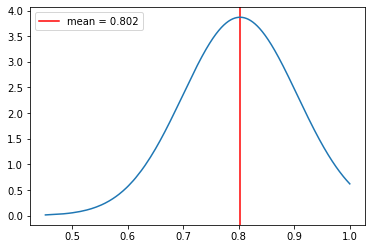

In [9]:
aspect_ratio_original.sort()

# Calculating mean and standard deviation
mean = np.mean(aspect_ratio_original)
std = np.std(aspect_ratio_original)
plt.axvline(x=mean, label = 'mean = {}'.format(round(mean,3)), c='r')
plt.plot(aspect_ratio_original, norm.pdf(aspect_ratio_original, mean, std))
plt.legend() 
plt.show()

In [10]:
import math

if cells[0][0] == 3: #If the mesh is triangular
    z1 = 3
    z2 = 5
    qe = 60
    
elif cells[0][0] == 4: #is the mesh is square
    z1 = 4
    z2 = 6
    qe = 90
    z3 = 2
    
q = len(cells) #the total number of cells in the mesh
p = []
i = 0
Skewness_original = []
distance = []

for y in range(0,q):
    for x in range(1,z2):
        if i < z1:
            a = points[cells[y][x]]
            p.append(a)
            i = i+1
        elif i == z1:
            
            if z1 ==3:
                for x in range(0,z1):
                    l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                    d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d)
                a = distance[1]
                b = distance[2]
                c = distance[0]
                alpha = math.degrees(math.acos((a**2-b**2-c**2)/(-2*b*c))) #calculates the angles of the corners
                beta = math.degrees(math.acos((b**2-c**2-a**2)/(-2*c*a)))
                gamma = math.degrees(math.acos((c**2-b**2-a**2)/(-2*b*a)))
                qmin = min(alpha, beta, gamma) #determines the minimal angle
                qmax = max(alpha, beta, gamma) #determines the maximal angle
                
            elif z1 == 4:
                for x in range(0,z1):
                    l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                    d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d)
                a = distance[0]
                b = distance[1]
                c = distance[2]
                d = distance[3]
                
                for x in range(0,z3):
                    l = abs(p[x%z1]-p[(x+2)%z1]) # calculates the difference in x and y coordinates of the points
                    d2 = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d2)
                    
                e = distance[4]
                f = distance[5]
                alpha1 = math.degrees(math.acos((b**2-e**2-a**2)/(-2*e*a))) #calculates the angles of the corners
                alpha2 = math.degrees(math.acos((d**2-f**2-c**2)/(-2*f*c)))
                alpha = alpha1+alpha2
                beta = math.degrees(math.acos((e**2-a**2-b**2)/(-2*a*b)))
                gamma1 = math.degrees(math.acos((a**2-e**2-b**2)/(-2*e*b)))
                gamma2 = math.degrees(math.acos((c**2-d**2-f**2)/(-2*d*f)))
                gamma = gamma1+gamma2
                delta = math.degrees(math.acos((f**2-d**2-c**2)/(-2*d*c)))
                qmin = min(alpha, beta, gamma) #determines the minimal angle
                qmax = max(alpha, beta, gamma) #determines the maximal angle
                
            skewness = max((qmax-qe)/(180-qe), (qe-qmin)/qe) 
            Skewness_original.append(skewness)
            i = 0
            p =[]
            distance = []
            
print('The average Skewness of the original mesh is', round(sum(Skewness_original)/len(Skewness_original),3))
print('The minimum Skewness of the original mesh is', round(min(Skewness_original),3))
print('the maximum Skewness of the original mesh is', round(max(Skewness_original),3))

The average Skewness of the original mesh is 0.205
The minimum Skewness of the original mesh is 0.0
the maximum Skewness of the original mesh is 0.552


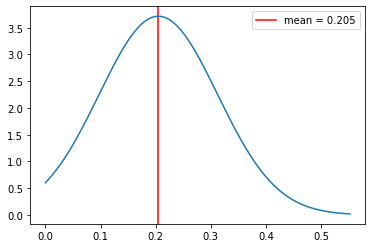

In [11]:
Skewness_original.sort()

# Calculating mean and standard deviation
mean = np.mean(Skewness_original)
std = np.std(Skewness_original)  
plt.axvline(x=mean, label = 'mean = {}'.format(round(mean,3)), c='r')
plt.plot(Skewness_original, norm.pdf(Skewness_original, mean, std))
plt.legend()
plt.show()

In [12]:
if cells[0][0] == 3: #If the mesh is triangular
    z1 = 3
    z2 = 5
    
elif cells[0][0] == 4: #If the mesh is square
    z1 = 4
    z2 = 6
    
#----------------------------------------------#
#----Creating a center point in each cell------#
#----------------------------------------------#

len_cells = len(cells) #the total number of cells in the mesh
len_points = len(points)
Orthogonality_original = []

if z1 ==3: #if triangle
    for y in range(0,len_cells):
        p=[]
        i = 0
        
        d = cells[y][1]
        e = cells[y][2]
        f = cells[y][3]
    
        for x in range(1,5):
            if i < z1:
                a = points[cells[y][x]]
                p.append(a)
                i = i+1
            elif i == z1:
                center = (p[0]+p[1]+p[2])/3
                point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
                point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
                point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side 
                
                e1= point1-center #center to point1
                e2= point2-center #center to point2
                e3= point3-center #center to point3
                vectors_e = [e1[:2],e2[:2],e3[:2]]
                
                v1= points[e]-points[d]
                v2= points[f]-points[e]
                v3= points[d]-points[f]
                
                #v=(a,b) u=(b,-a) #perpendicular
                A1= (v1[1],-v1[0]) #perpendicular to side de
                A2= (v2[1],-v2[0])#perpendicular to side ef
                A3= (v3[1],-v3[0])#perpendicular to side fd
                vectors_A=[A1,A2,A3]
                
                orth = []
                for o in range(0,3):
                    dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
                    magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
                    magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
                    ort = (dot_e_A)/(magnitude_e*magnitude_A)
                    orth.append(ort)
                Orthogonality_original.append(min(orth))

                                        
elif z1==4: #if square

    for y in range(0,len_cells):
        p=[]
        i = 0
        
        d = cells[y][1]
        e = cells[y][2]
        f = cells[y][3]
        g = cells[y][4]
        
        for x in range(1,5):
            if i < z1:
                a = points[cells[y][x]]
                p.append(a)
                i = i+1
            elif i == z1:
                center = (p[0]+p[1]+p[2]+p[3])/4
                point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
                point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
                point3 = ((points[g]+points[f])/2) #creating a additional point in the middle of the third edge of the side
                point4 = ((points[f]+points[d])/2) #creating a additional point in the middle of the third edge of the side
                
                e1= point1-center #center to point1
                e2= point2-center #center to point2
                e3= point3-center #center to point3
                e4= point4-center #center to point4
                vectors_e = [e1[:2],e2[:2],e3[:2], e4[:2]]
                
                v1= points[e]-points[d]
                v2= points[f]-points[e]
                v3= points[g]-points[f]
                v4= points[d]-points[g]
                
                #v=(a,b) u=(b,-a) #perpendicular
                A1= (v1[1],-v1[0]) #perpendicular to side de
                A2= (v2[1],-v2[0])#perpendicular to side ef
                A3= (v3[1],-v3[0])#perpendicular to side fg
                A3= (v4[1],-v4[0])#perpendicular to side gd
                vectors_A=[A1,A2,A3,A4]
                
                orth = []
                for o in range(0,4):
                    dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
                    magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
                    magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
                    ort = (dot_e_A)/(magnitude_e*magnitude_A)
                    orth.append(ort)
                Orthogonality_original.append(min(orth))

print('The average Face Orthogonality of the mesh is', round(sum(Orthogonality_original)/len(Orthogonality_original),3))
print('The minimum Face Orthogonality of the mesh is', round(min(Orthogonality_original),3))
print('The maximum Face Orthogonality of the mesh is', round(max(Orthogonality_original),3))  

The average Face Orthogonality of the mesh is 0.96
The minimum Face Orthogonality of the mesh is 0.654
The maximum Face Orthogonality of the mesh is 1.0


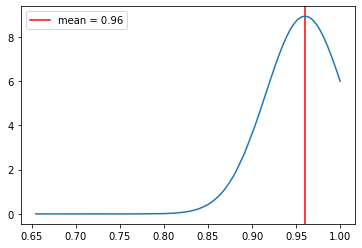

In [13]:
Orthogonality_original.sort()

# Calculating mean and standard deviation
mean = np.mean(Orthogonality_original)
std = np.std(Orthogonality_original)  
plt.axvline(x=mean, label = 'mean = {}'.format(round(mean,3)), c='r')
plt.plot(Orthogonality_original, norm.pdf(Orthogonality_original, mean, std))
plt.legend()
plt.show()

# Visualizing the mesh

C:\Users\20192167\Anaconda3\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


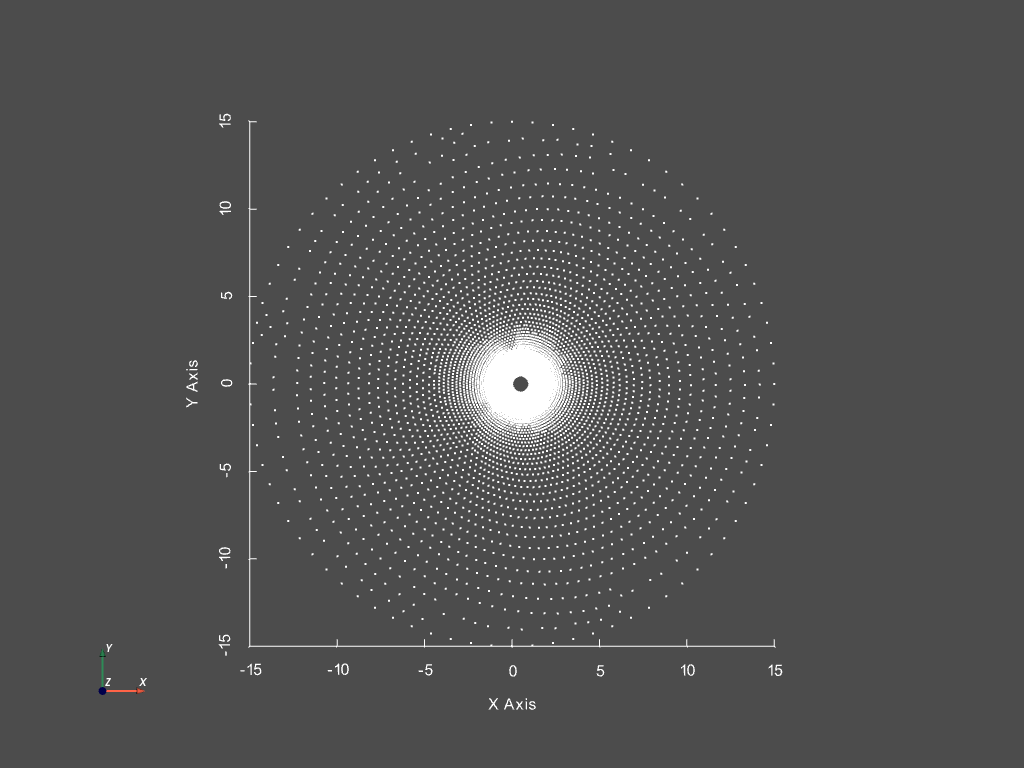

In [14]:
mesh = pv.PolyData(points)
mesh.plot(show_bounds=True, cpos='xy', point_size=2)

In [15]:
mesh = pv.PolyData(points, cells)
mesh

PolyData,Information
N Cells,26192
N Points,13336
X Bounds,"-1.500e+01, 1.500e+01"
Y Bounds,"-1.500e+01, 1.500e+01"
Z Bounds,"0.000e+00, 0.000e+00"
N Arrays,0


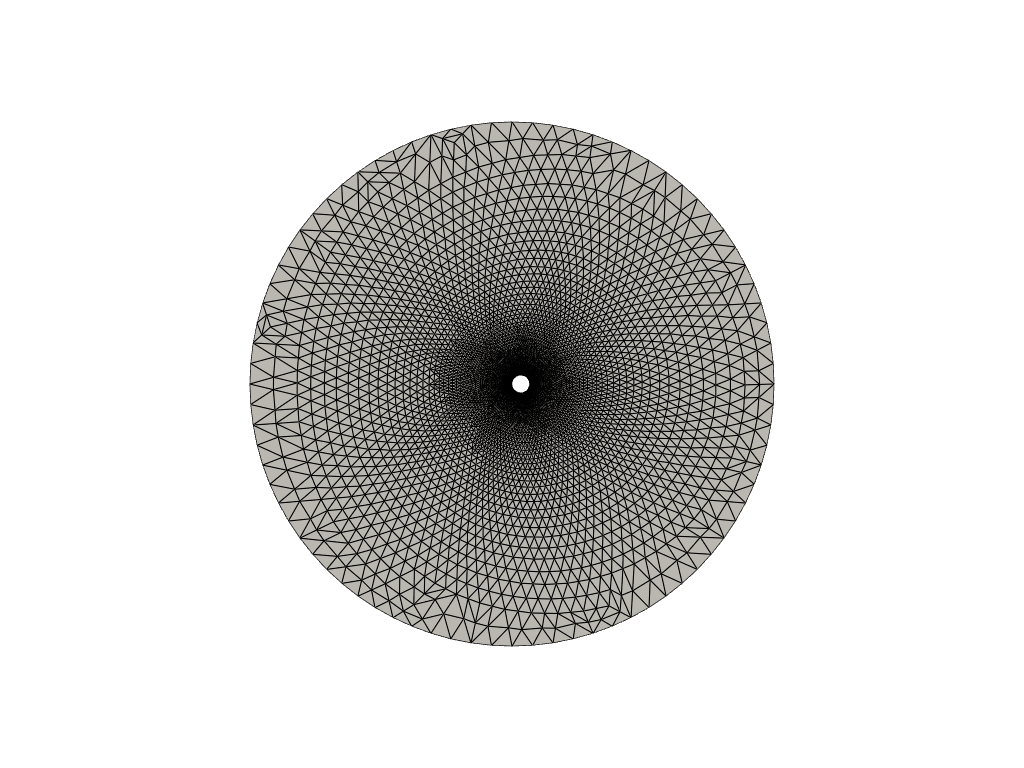

In [16]:
mesh = pv.PolyData(points, connectivity)
pl = pv.Plotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

In [17]:
import numpy as np
import pyvista
import math

**The array {c} contains all the index numbers you wish to refine**

In [19]:
c = [1,2,3,4,5,6,7,8,9,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,2012,4514,4515,4513,234,26190,26189,26191] #number of the cell you wish to refine

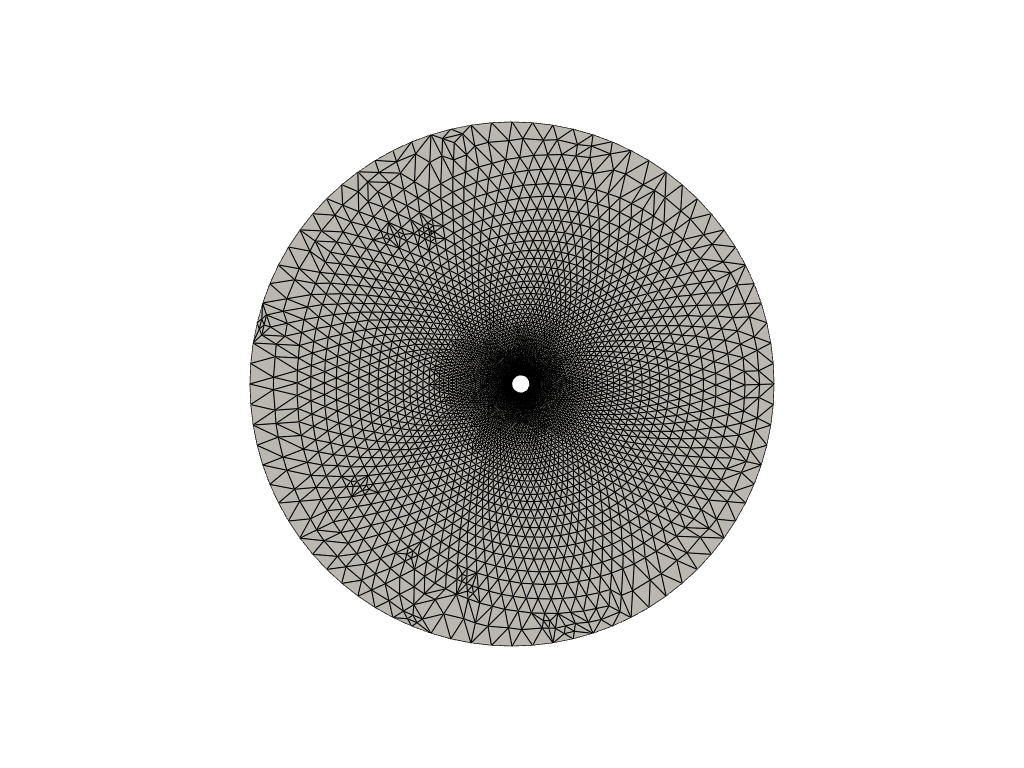

In [20]:
#-------------------------------------------------------------------------------#    
#--------Finding the neighbouring cells of the cells you wish to refine---------#
#-------------------------------------------------------------------------------#

len_points = len(points) #the total number of points in the mesh
len_cells = len(cells) #the total number of cells in the mesh
  
clen = len(c) #the total number of cells you wish to refine
ytotal = []  #numbers of the neigbouring cells of all cells you wish to refine in array per cell
ytotaly = [] #numbers of the neigbouring cells of all cells you wish to refine

for cx in range(0,clen): #for every cell listed in array {c}
    
    d = cells[c[cx]][1] #the first point of the cell
    e = cells[c[cx]][2] #the second point of the cell
    f = cells[c[cx]][3] #the third point of the cell
    cy=[d,e,f] #the numbers of the points creating the cell

    y = [] #numbers of the neighbouring cells of cell cx
    v = 0 #temporary variable

    for x in range(0,len_cells): #for all cells in the mesh
        if d in cells[x][1:] and e in cells[x][1:]: #looks for the side DE in the other cells
            if x not in c:
                y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                ytotaly.append(x)
                v=1
    if v!= 1:
        y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
        ytotaly.append(len_cells+1)
        
    v=0
    for x in range(0,len_cells): #for all cells in the mesh
        if e in cells[x][1:] and f in cells[x][1:]: #looks for the side EF in the other cells
            if x not in c:
                y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                ytotaly.append(x)
                v=1
    if v!= 1:
        y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
        ytotaly.append(len_cells+1)
        
    v=0
    for x in range(0,len_cells): #for all cells in the mesh
        if d in cells[x][1:] and f in cells[x][1:]: #looks for the side DF in the other cells
            if x not in c:
                y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                ytotaly.append(x)
                v=1   
    if v!= 1:
        y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
        ytotaly.append(len_cells+1)
        
    ytotal.append(y)
    
#-------------------------------------------------------------------------#
#---------Finding neighbouring cells that are called for twice------------#
#-------------------------------------------------------------------------#
i=0
for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
    for z in range(0,3): 
        
        if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
            if ytotal[x][z] != len_cells+1: #if it is not the additional cell added for no connection
                if ytotal[x] not in c: #if the cell is not listed in {c}
                    c.append(ytotal[x][z]) #add the cell to {c}
                    v =1
            else:
                v=0
        else:
            v =0

    i = i+3
if len(c)==clen: #if at least two cells share the same neighbouring cell. The code will be ran again.
    a=1
    
else:
    while True:
        clen=len(c) #the new total number of cells you wish to refine
        ytotal = [] #numbers of the neigbouring cells of all cells you wish to refine
        ytotaly= []
        #-------------------------------------------------------------------------------#    
        #--------Finding the neighbouring cells of the cells you wish to refine---------#
        #-------------------------------------------------------------------------------#

        for cx in range(0,clen): #for every cell listed in array {c}
    
            d = cells[c[cx]][1] #the first point of the cell
            e = cells[c[cx]][2] #the second point of the cell
            f = cells[c[cx]][3] #the third point of the cell
            cy=[d,e,f] #the numbers of the points creating the cell

            y = [] #numbers of the neighbouring cells of cell cx
            v = 0 #temporary variable

            for x in range(0,len_cells): #for all cells in the mesh
                if d in cells[x][1:] and e in cells[x][1:]: #looks for the side DE in the other cells
                    if x not in c:
                        y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                        ytotaly.append(x)
                        v=1
            if v!= 1:
                y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
                ytotaly.append(len_cells+1)

            v=0
            for x in range(0,len_cells): #for all cells in the mesh
                if e in cells[x][1:] and f in cells[x][1:]: #looks for the side EF in the other cells
                    if x not in c:
                        y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                        ytotaly.append(x)
                        v=1
            if v!= 1:
                y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
                ytotaly.append(len_cells+1)

            v=0
            for x in range(0,len_cells): #for all cells in the mesh
                if d in cells[x][1:] and f in cells[x][1:]: #looks for the side DF in the other cells
                    if x not in c:
                        y.append(x) #if a second listing of DF is present the number of that cell is added to the list
                        ytotaly.append(x)
                        v=1   
            if v!= 1:
                y.append(len_cells+1) #adds a cell that is not in the mesh to the array {y}
                ytotaly.append(len_cells+1)

            ytotal.append(y)

        #-------------------------------------------------------------------------#
        #---------Finding neighbouring cells that are called for twice------------#
        #-------------------------------------------------------------------------#

        i=0
        for x in range (0,len(ytotal)): #for every cell listed in {ytotal}
            for z in range(0,3): 

                if ytotal[x][z] in ytotaly[3+i:]: #if the cell is listed again in {ytotal}
                    if ytotal[x][z] != len_cells+1: #if it is not the additional cell added for no connection
                        if ytotal[x] not in c: #if the cell is not listed in {c}
                            c.append(ytotal[x][z]) #add the cell to {c}
                            v =1
                    else:
                        v=0
                else:
                    v =0

            i = i+3

        if len(c)==clen: #if at least two cells share the same neighbouring cell. The code will be ran again.
            break

            
#------------------------------------------------------------------#
#--------Taking out the cells that are already to be refined-------#
#------------------------------------------------------------------#

yleft = ytotal #the numbers of the cells that need to be split in two

for x in range (0,len(ytotal)): #for all neigbouring cells
    for z in range(0,3): 
        if ytotal[x][z] in c: #if a cell listed in {ytotal} is already in {c}
            yleft[x][z] = len_cells+1 #all cells that are already being refined are replaced by the number len_cells+1
        elif ytotal:
            v=0
            
#---------------------------------------------------------------#
#--------Determining which point the cells do not share---------#
#---------------------------------------------------------------#

r=[] #an array containing a 1 for sharing and a 0 for not sharing
for cx in range(0,clen):
    rx = [] #temporary storange array
    y = yleft[cx] #the numbers of the neigbouring cells
        
    d = cells[c[cx]][1] #first point of the cell
    e = cells[c[cx]][2] #second point of the cell
    f = cells[c[cx]][3] #third point of the cell
    cy=[d,e,f] #the numbers of the points creating the cell
    
    for x in range (0,3):
        if y[x] <= len_cells:
            q = cells[y[x]][1:] #points in the neighbouring cell
            for x in range (0,3):
                q1 = q[x]
                if q1 in cy: #if two cells share a point
                    t = 1
                    rx.append(t)
                else: # if two cells do not share a point
                    t = 0
                    rx.append(t)
        else:
            rx.append(0)
            rx.append(0)
            rx.append(0)
    r.append(rx)

#---------------------------------------#
#-----Splitting the cell in four--------# 
#---------------------------------------#
for cx in range(0,clen):
     
    d = cells[c[cx]][1]
    e = cells[c[cx]][2]
    f = cells[c[cx]][3]
    
    point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
    point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
    point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side
    points = np.vstack([points,point1,point2,point3]) #adding the points to the points array
    
    g = len(points) #the new total number of points
    
    #changing the original cell to to the refined cell
    cells[c[cx]]= [3, (g-1),(g-2),f] 
    cells = np.vstack([cells, [3, d,(g-1),(g-3)]])
    cells = np.vstack([cells, [3, (g-2),e,(g-3)]])
    cells = np.vstack([cells, [3, (g-1),(g-2),(g-3)]])
    
    #------------------------------------#
    #------Adjusting marker lines--------#
    #------------------------------------#
    
    for x in range(0,len(markers)): #for all cells in the mesh

        if d in markers[x] and e in markers[x]: #looks for the side DE in the other cells
            mmarker = []
            mcell = []
            mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
            mcell.append(c[cx])

            if c[cx] in mcell:
                markers[mmarker[0]+1:mmarker[0]+1] = [[(g-3), markers[mmarker[0]][1]]]
                markers[mmarker[0]] = [markers[mmarker[0]][0], (g-3)]
                

    for x in range(0,len(markers)): #for all cells in the mesh
        if e in markers[x] and f in markers[x]: #looks for the side DE in the other cells
            mmarker = []
            mcell = []
            mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
            mcell.append(c[cx])

            if c[cx] in mcell:
                markers[mmarker[0]+1:mmarker[0]+1] = [[(g-2), markers[mmarker[0]][1]]]
                markers[mmarker[0]] = [markers[mmarker[0]][0], (g-2)]
                
                
    for x in range(0,len(markers)): #for all cells in the mesh
        if f in markers[x] and d in markers[x]: #looks for the side DE in the other cells
            mmarker = []
            mcell = []
            mmarker.append(x) #if a second listing of DF is present the number of that cell is added to the list
            mcell.append(c[cx])

            if c[cx] in mcell:
                markers[mmarker[0]+1:mmarker[0]+1] = [[(g-1), markers[mmarker[0]][1]]]
                markers[mmarker[0]] = [markers[mmarker[0]][0], (g-1)]
        
#-------------------------------------------------#   
#---------Splitting the neighbouring cells--------#
#-------------------------------------------------#

for cx in range(0,len(c)):
    j = 0
    h = 0
    p = [] #a storange array for the following for loop
    n = []
    m = [] #an array containing the index numbers of the overlapping points
    rx = r[cx]
    for x in range(0,len(rx)+1):
        if j < 3: 
            a = rx[x]
            p.append(a)
            j = j+1
        elif j == 3:  
            for z in range(0,3):
                z1=p[z]
                if z1==1:
                    n.append(z)
                    h=h+1
                    if h == 2:
                        m.append(n[0])
                        m.append(n[1])
                        n = []
            h = 0 
            p = [] 
            n = []

            if x < 9:
                a = rx[x]
                p.append(a)
            j=1
            h=0
    n=3
    g=len(points)-3*(len(c)-cx-1)
    j=0 
    y = yleft[cx]
        #Splitting the neigbouring cells in two
    for z in range(0,3):
        u = y[z]
        if u <= len_cells:
            d1 = cells[y[z]][1]
            e1 = cells[y[z]][2]
            f1 = cells[y[z]][3]
            cell = [3, d1, e1, f1]
            cell[m[j]+1] = g-n   
            cells[y[z]]= cell
            j=j+1
            cell = [3, d1, e1, f1]
            cell[m[j]+1] = g-n
            cells = np.vstack([cells, cell])  
            j=j+1
        n=n-1

#-------------------------------------------#
#---------Plotting the new mesh-------------#
#-------------------------------------------#
mesh = pyvista.PolyData(points, cells)
pl = pyvista.Plotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.05, color='#EEEEEE')
pl.set_background('white')
#pl.add_point_labels(points, [f'Point {i}' for i in range(5)],always_visible=True,
#                    font_size=20,text_color='white', point_size=20,point_color='red',render_points_as_spheres=True)
pl.camera_position = 'xy'
pl.show()

**Exporting the new mesh file**

In [ ]:
file_path = 'C:\\Users\\20192167\\Documents\\Boeken\\BEP\data.txt'
with open(file_path, 'w') as fp: 
    text = 'NDIME= '+ NDIME + '\n'
    fp.write(text) 
    
    len_cells = str(len(cells))
    text = 'NELEM= ' + len_cells + '\n'
    fp.write(text) 
    
    for y in range (0,len(cells)):
        ELEM2 = int(5), int(cells[y][1]), int(cells[y][2]), int(cells[y][3]), int(y)
        text = " " + '\t'.join(str(x) for x in ELEM2) + '\n'
        fp.write(text)
    
    len_points = str(len(points))
    text = 'NPOIN= ' + len_points + '\n'
    fp.write(text)
    
    for y in range (0,len(points)):
        POIN2 = points[y][0], points[y][1], int(y)
        text = '\t' + " " + '\t'.join(str(x) for x in POIN2) + '\n'
        fp.write(text)

    
    text = 'NMARK= ' + NMARK + '\n'
    fp.write(text)

    
    for x in range(0, len(markerelements)):
        text = 'MARKER_TAG= ' + markername[x] + '\n'
        fp.write(text)  


        marker_elements = str(markerelements[x])
        text = 'MARKER_ELEMS= ' + marker_elements + '\n'
        fp.write(text)  


        for y in range (0,len(markers[x])):
            MARK = str(3), markers[x][y][0], markers[x][y][1]
            text = " " + '\t'.join(str(x) for x in MARK) + '\n'
            fp.write(text)  


**Mesh Quality Analysis**

In [ ]:
import math

if cells[0][0] == 3: #If the mesh is triangular
    z1 = 3
    z2 = 5
elif cells[0][0] == 4: #is the mesh is square
    z1 = 4
    z2 = 6

q = len(cells) #Total number of cells
p = [] #A temporary array to store the points of the cell of interest
i = 0
aspect_ratio = []
distance = [] #A temporary array containing the lenghts of the edges

for y in range(0,q):
    for x in range(1,z2):
        if i < z1:
            a = points[cells[y][x]]
            p.append(a)
            i = i+1
        elif i == z1:
            for x in range(0,z1):
                l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                distance.append(d)
            ar = min(distance)/max(distance)
            aspect_ratio.append(ar)
            i = 0
            p =[]
            distance = []

            
print('The average Aspect Ratio of the mesh is', round(sum(aspect_ratio)/len(aspect_ratio),3))
print('The minimum Aspect Ratio of the mesh is', round(min(aspect_ratio),3))
print('the maximum Aspect Ratio of the mesh is', round(max(aspect_ratio),3))

In [ ]:
aspect_ratio.sort()

# Calculating mean and standard deviation
mean = np.mean(aspect_ratio)
std = np.std(aspect_ratio)
plt.axvline(x=mean, label = 'mean = {}'.format(round(mean,3)), c='r')
plt.plot(aspect_ratio, norm.pdf(aspect_ratio, mean, std))
plt.legend() 
plt.show()

In [ ]:
import math

if cells[0][0] == 3: #If the mesh is triangular
    z1 = 3
    z2 = 5
    qe = 60
    
elif cells[0][0] == 4: #is the mesh is square
    z1 = 4
    z2 = 6
    qe = 90
    z3 = 2
    
q = len(cells) #the total number of cells in the mesh
p = []
i = 0
Skewness = []
distance = []

for y in range(0,q):
    for x in range(1,z2):
        if i < z1:
            a = points[cells[y][x]]
            p.append(a)
            i = i+1
        elif i == z1:
            
            if z1 ==3:
                for x in range(0,z1):
                    l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                    d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d)
                a = distance[1]
                b = distance[2]
                c = distance[0]
                alpha = math.degrees(math.acos((a**2-b**2-c**2)/(-2*b*c))) #calculates the angles of the corners
                beta = math.degrees(math.acos((b**2-c**2-a**2)/(-2*c*a)))
                gamma = math.degrees(math.acos((c**2-b**2-a**2)/(-2*b*a)))
                qmin = min(alpha, beta, gamma) #determines the minimal angle
                qmax = max(alpha, beta, gamma) #determines the maximal angle
                
            elif z1 == 4:
                for x in range(0,z1):
                    l = abs(p[x%z1]-p[(x+1)%z1]) # calculates the difference in x and y coordinates of the points
                    d = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d)
                a = distance[0]
                b = distance[1]
                c = distance[2]
                d = distance[3]
                
                for x in range(0,z3):
                    l = abs(p[x%z1]-p[(x+2)%z1]) # calculates the difference in x and y coordinates of the points
                    d2 = math.sqrt(l[0]**2 + l[1]**2) # calculates the length of the edges
                    distance.append(d2)
                    
                e = distance[4]
                f = distance[5]
                alpha1 = math.degrees(math.acos((b**2-e**2-a**2)/(-2*e*a))) #calculates the angles of the corners
                alpha2 = math.degrees(math.acos((d**2-f**2-c**2)/(-2*f*c)))
                alpha = alpha1+alpha2
                beta = math.degrees(math.acos((e**2-a**2-b**2)/(-2*a*b)))
                gamma1 = math.degrees(math.acos((a**2-e**2-b**2)/(-2*e*b)))
                gamma2 = math.degrees(math.acos((c**2-d**2-f**2)/(-2*d*f)))
                gamma = gamma1+gamma2
                delta = math.degrees(math.acos((f**2-d**2-c**2)/(-2*d*c)))
                qmin = min(alpha, beta, gamma) #determines the minimal angle
                qmax = max(alpha, beta, gamma) #determines the maximal angle
                
            skewness = max((qmax-qe)/(180-qe), (qe-qmin)/qe) 
            Skewness.append(skewness)
            i = 0
            p =[]
            distance = []
            
print('The average Skewness of the mesh is', round(sum(Skewness)/len(Skewness),3))
print('The minimum Skewness of the mesh is', round(min(Skewness),3))
print('the maximum Skewness of the mesh is', round(max(Skewness),3))

In [ ]:
mesh.cell_data['Skewness']= Skewness
mesh.cell_data['Skewness']
pl = pyvista.Plotter()
pl.add_mesh(mesh, show_edges=True, line_width=0.5)
pl.set_background('white')
_ = pl.add_scalar_bar('Skewness', interactive=True, vertical=False,
                           title_font_size=35,
                           label_font_size=30,
                           outline=True, fmt='%50.5f')
pl.camera_position = 'xy'
pl.show()

In [ ]:
Skewness.sort()

# Calculating mean and standard deviation
mean = np.mean(Skewness)
std = np.std(Skewness)  
plt.axvline(x=mean, label = 'mean = {}'.format(round(mean,3)), c='r')
plt.plot(Skewness, norm.pdf(Skewness, mean, std))
plt.legend()
plt.show()

In [ ]:
if cells[0][0] == 3: #If the mesh is triangular
    z1 = 3
    z2 = 5
    
elif cells[0][0] == 4: #If the mesh is square
    z1 = 4
    z2 = 6
    
#----------------------------------------------#
#----Creating a center point in each cell------#
#----------------------------------------------#

len_cells = len(cells) #the total number of cells in the mesh
len_points = len(points)
Orthogonality = []

if z1 ==3: #if triangle
    for y in range(0,len_cells):
        p=[]
        i = 0
        
        d = cells[y][1]
        e = cells[y][2]
        f = cells[y][3]
    
        for x in range(1,5):
            if i < z1:
                a = points[cells[y][x]]
                p.append(a)
                i = i+1
            elif i == z1:
                center = (p[0]+p[1]+p[2])/3
                point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
                point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
                point3 = ((points[d]+points[f])/2) #creating a additional point in the middle of the third edge of the side 
                
                e1= point1-center #center to point1
                e2= point2-center #center to point2
                e3= point3-center #center to point3
                vectors_e = [e1[:2],e2[:2],e3[:2]]
                
                v1= points[e]-points[d]
                v2= points[f]-points[e]
                v3= points[d]-points[f]
                
                #v=(a,b) u=(b,-a) #perpendicular
                A1= (v1[1],-v1[0]) #perpendicular to side de
                A2= (v2[1],-v2[0])#perpendicular to side ef
                A3= (v3[1],-v3[0])#perpendicular to side fd
                vectors_A=[A1,A2,A3]
                
                orth = []
                for o in range(0,3):
                    dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
                    magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
                    magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
                    ort = (dot_e_A)/(magnitude_e*magnitude_A)
                    orth.append(ort)
                Orthogonality.append(min(orth))

                                        
elif z1==4: #if square

    for y in range(0,len_cells):
        p=[]
        i = 0
        
        d = cells[y][1]
        e = cells[y][2]
        f = cells[y][3]
        g = cells[y][4]
        
        for x in range(1,5):
            if i < z1:
                a = points[cells[y][x]]
                p.append(a)
                i = i+1
            elif i == z1:
                center = (p[0]+p[1]+p[2]+p[3])/4
                point1 = ((points[e]+points[d])/2) #creating a additional point in the middle of the first edge of the side
                point2 = ((points[f]+points[e])/2) #creating a additional point in the middle of the second edge of the side
                point3 = ((points[g]+points[f])/2) #creating a additional point in the middle of the third edge of the side
                point4 = ((points[f]+points[d])/2) #creating a additional point in the middle of the third edge of the side
                
                e1= point1-center #center to point1
                e2= point2-center #center to point2
                e3= point3-center #center to point3
                e4= point4-center #center to point4
                vectors_e = [e1[:2],e2[:2],e3[:2], e4[:2]]
                
                v1= points[e]-points[d]
                v2= points[f]-points[e]
                v3= points[g]-points[f]
                v4= points[d]-points[g]
                
                #v=(a,b) u=(b,-a) #perpendicular
                A1= (v1[1],-v1[0]) #perpendicular to side de
                A2= (v2[1],-v2[0])#perpendicular to side ef
                A3= (v3[1],-v3[0])#perpendicular to side fg
                A3= (v4[1],-v4[0])#perpendicular to side gd
                vectors_A=[A1,A2,A3,A4]
                
                orth = []
                for o in range(0,4):
                    dot_e_A = abs((vectors_A[o][0]*vectors_e[o][0])+(vectors_A[o][1]*vectors_e[o][1]))
                    magnitude_e = math.sqrt((vectors_e[o][0])**2+(vectors_e[o][1])**2)
                    magnitude_A = math.sqrt((vectors_A[o][0])**2+(vectors_A[o][1])**2)
                    ort = (dot_e_A)/(magnitude_e*magnitude_A)
                    orth.append(ort)
                Orthogonality.append(min(orth))

print('The average Face Orthogonality of the mesh is', round(sum(Orthogonality)/len(Orthogonality),3))
print('The minimum Face Orthogonality of the mesh is', round(min(Orthogonality),3))
print('the maximum Face Orthogonality of the mesh is', round(max(Orthogonality),3))                